Full testing/ training of 

LinearRegression, KNeighborsRegressor, and keras CNN

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks, argrelmin, find_peaks_cwt
from collections import Counter
from scipy import signal
from pathlib import Path
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D,ConvLSTM1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Run this to get started
path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')


dictionary_aurora_50_sampled_path = "measurements_auscultatory_dictionary_ALL.pkl"
auscultatory_data = path_aurora_dataset / "measurements_auscultatory.tsv"
participants_data =  path_aurora_dataset / "participants.tsv"

# Use pwdb_model_configs file
participants_dps_csv_data = pd.read_csv("/Users/cslinxs/Desktop/all_weeks/pwdb_model_configs.csv")




with open(dictionary_aurora_50_sampled_path, 'rb') as handle:
    all_auscultatory_dic = pickle.load(handle)


bad_keys = []
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        bad_keys.append(key)
print(bad_keys)

for key in bad_keys:
    del all_auscultatory_dic[key]




keys_for_grouping = [
"Calibration_start",#0
"Static_challenge_start",#1
"Seated_calibration",#2
"Static_seated_challenge",#3
"Exercise_challenge_start",#4
"Temporal_challenge_start",#5
"Temporal_seated_challenge"]#6

['measurements_auscultatory/a064/a064.initial.Static_seated_challenge_1.tsv', 'measurements_auscultatory/a150/a150.return.Temporal_challenge_start_3.tsv', 'measurements_auscultatory/a328/a328.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a578/a578.initial.Static_challenge_start_1.tsv', 'measurements_auscultatory/a596/a596.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a642/a642.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a648/a648.initial.Seated_calibration_1.tsv', 'measurements_auscultatory/a437/a437.initial.Exercise_challenge_start_2.tsv', 'measurements_auscultatory/a437/a437.return.Temporal_seated_challenge_2.tsv']


In [68]:
#all functions
def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list, default="EMPTY"),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]

def reject_outliers(data):
    return data[abs(data - np.mean(data)) <3 * np.std(data)]

def get_50_avg_coordinates(path):
    print(path)
    df = pd.read_csv(path,sep = '\t')   
    pos_pressure = df["pressure"]

    neglist = [ -x for x in pos_pressure]

    # ADD THE DROPPING DWOAN AND GETMIN BELLOW a LINE
    b, a = signal.butter(1, 0.002, analog=False)
    gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
    y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

    y_flater = np.array(y_flater)
    neglist = [ -x for x in y_flater]

    neg_max_values = max(neglist)
    neg_mix_values = min(neglist)
    mid_neg_value= neg_max_values - neg_mix_values

    min_height = neg_max_values - mid_neg_value*0.15 

    min_peaks, _ = find_peaks(neglist , height= min_height)

    
    most_accurate_mins = min_peaks
    diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

    mean_new_min = float(diffrences_new_min.mean())
    overlapped_means = pd.DataFrame( )

    nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)
    
    for i in range(len(most_accurate_mins)-1):
        
        current_pulse_width = int(most_accurate_mins[i+1]) -int(most_accurate_mins[i])
        if (current_pulse_width)< get_stats(diffrences_new_min)[4] and (current_pulse_width)> get_stats(diffrences_new_min)[1]:
            y_range  = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]


            start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)
            y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]
            
            if len(y_rotated)>=int(mean_new_min):

                pulse_data_cut_short = pd.Series(list(y_rotated)[:int(mean_new_min)] )

                overlapped_means = pd.concat([overlapped_means, pulse_data_cut_short.rename(f"pulse {i}")], axis=1)
            else:
                
                pulse_data_and_Nan_filler = pd.Series(list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)]) )

                overlapped_means = pd.concat([overlapped_means, pulse_data_and_Nan_filler.rename(f"pulse {i}")], axis=1)

    overlapped_means['mean'] = overlapped_means.mean(axis=1)
    all_overlaps_means = (overlapped_means.mean(axis=1))
    resampled_y = signal.resample(all_overlaps_means, 50)
    return resampled_y



# Filter by activity
# Filters to activty's first file no overlap
def filter_by_activity(activity_number=1):
    if activity_number ==-1:
        auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
        auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]
        auscultatory_dbp = [item[2] for item in all_auscultatory_dic.values()]
        return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 
    activity_tested_on = activity_number
    

    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for key, each_grouping in all_auscultatory_dic.items():
        if not(f"{keys_for_grouping[activity_tested_on]}_1" in  key):
            del title_filtered_all_auscultatory_dic[key]
    auscultatory_pressure =[item[0] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_sbp = [item[1] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_dbp = [item[2] for item in title_filtered_all_auscultatory_dic.values()]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 


def filter_by_hypertension(activity_number=1):
    participants_auroa_data = pd.read_csv(participants_data, sep = '\t')
    participants_csv_htn = participants_auroa_data[participants_auroa_data["self_report_htn"].isin(["managed","unmanaged"])]
    participants_csv_htn = participants_csv_htn[participants_csv_htn["pid"].str.contains('a')]
    people_htn = participants_csv_htn["pid"]

    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for key, each_grouping in all_auscultatory_dic.items():
        person_id = key.split("_")[1].split("/")[1]
        if not(person_id in list(people_htn)): 
            del title_filtered_all_auscultatory_dic[key]


    if activity_number ==-1:
        auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
        auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]
        auscultatory_dbp = [item[2] for item in all_auscultatory_dic.values()]
        return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 
    activity_tested_on = activity_number
    
    title_filtered_all_auscultatory_dic_2= dict(title_filtered_all_auscultatory_dic) 
    for key, each_grouping in title_filtered_all_auscultatory_dic.items():
        if not(f"{keys_for_grouping[activity_tested_on]}_1" in  key):
            del title_filtered_all_auscultatory_dic_2[key]
    auscultatory_pressure =[item[0] for item in title_filtered_all_auscultatory_dic_2.values()]
    auscultatory_sbp = [item[1] for item in title_filtered_all_auscultatory_dic_2.values()]
    auscultatory_dbp = [item[2] for item in title_filtered_all_auscultatory_dic_2.values()]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_sbp(SBP_range = (120,120), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_sbp)) if (float(auscultatory_dbp[sb])<=SBP_range[0] and float(auscultatory_sbp[sb])>SBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_dbp(DBP_range = (70,80), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_dbp)) if (float(auscultatory_dbp[sb])<=DBP_range[0] and float(auscultatory_dbp[sb])>DBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 


def filter_charlton_subjects():
    charlton_point_dbp = [[],[],[]]

    # will track age,dbp values
    charlton_set_seen_duplicates =set()

    Charlton_dataset_csv = "/Users/cslinxs/Desktop/all_weeks/Charlton_dataset_csv"
    for files in os.listdir(Charlton_dataset_csv):
        if "_P.Csv" in files.title() and "Digital" in files.title():
            body_part = files.title().split("_")[1]
            function = files.title().split("_")[2]
            participants_csv_data = pd.read_csv(Charlton_dataset_csv+"/"+files)
            
            for i in range(len(participants_csv_data)):
                y_points = participants_csv_data.iloc[i][1:].dropna()
                
                resampled_y = signal.resample(y_points, 50)
                resampled_y = [int(y - min(resampled_y)) for y in resampled_y]
                
                if not(True in list(np.isnan(resampled_y))):
                    indivuals_set = (participants_dps_csv_data.get(" age [years]")[i],participants_dps_csv_data.get(" dbp [mmHg]")[i],participants_dps_csv_data.get(" pvr [Pa s/m^3]")[i])
                    if not(indivuals_set in charlton_set_seen_duplicates):
                        charlton_point_dbp[0].append(resampled_y)
                        charlton_point_dbp[1].append(participants_dps_csv_data.get(" dbp [mmHg]")[i])
                        charlton_point_dbp[2].append(participants_dps_csv_data.get(" mbp [mmHg]")[i])
                        
                        charlton_set_seen_duplicates.add(indivuals_set)
    return charlton_point_dbp[0], charlton_point_dbp[1]

def LinearRegression_plot_MAE( activity_number=1):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)

    all_points = np.array(auscultatory_pressure)
    all_points = all_points.reshape(all_points.shape[0], -1)

    plt.figure(figsize=(5, 5)) 
    neigh = LinearRegression()


    X_train, X_test, Y_train, Y_test = train_test_split(all_points, auscultatory_dbp, test_size=0.3)




    the_fit= neigh.fit(X_train, Y_train)

    y_predict= neigh.predict(X_test)

    plt.rcParams.update({'font.size': 10})

    plt.plot(Y_test, Y_test, color="grey", linewidth=2, alpha=0.9)


    plt.scatter(Y_test, list(y_predict),  color="red",  alpha=0.5,s=50 )
    plt.title(f"LinearRegression Activity: {keys_for_grouping[activity_number]}")
    plt.xlabel("Tested DBP value")
    plt.ylabel("Predicted DBP value")

    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.4,s=f"MAE {round(mean_absolute_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.2, s= f"RMS {round(root_mean_squared_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin, s= f"r2 {round(r2_score(Y_test, y_predict),2)}", fontsize=12)
    plt.show()
    return round(mean_absolute_error(Y_test, y_predict),2)


def KNN_MAE_cross( activity_number=1, bp_variable = "s", n_neighbors=1, cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def LinearRegression_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = LinearRegression()

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

                    

def CNN_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        # auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        # bp_variable_val = auscultatory_dbp
        print("Use [CNN_MAE_cross_charlton] method")
        return None
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp


    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)
            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])
            return model
        model = create_model()
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
        

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def CNN_MAE_cross_charlton( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure[0:cross_valid_space] + auscultatory_pressure[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:cross_valid_space] +bp_variable_val[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        
        X_other = auscultatory_pressure[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(bp_variable_val[cross_valid_space:cross_valid_space+50])

        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]


def CNN_MAE_cross_simvreal( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = [], [], []

    bp_variable_val = None

    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp

        auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(activity_number)
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure[0:cross_valid_space] + auscultatory_pressure[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:cross_valid_space] +bp_variable_val[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        

        #tested on real
        X_other = auscultatory_pressure_real[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(auscultatory_dbp_real[cross_valid_space:cross_valid_space+50])

        #trained on simulation
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    print(all_mea)

    def plot_history(history):
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error')
        plt.plot(history.epoch, np.array(history.history['mae']), 
                label='Train')
        plt.plot(history.epoch, np.array(history.history['val_mae']),
                label = 'Val')
        plt.legend()
        plt.ylim([min(history.history['val_mae']),max(history.history['val_mae'])])
    plot_history(history)


    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]


def CNN_MAE_cross_realvsim( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = [], [], []

    bp_variable_val = None

    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp

        auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(activity_number)
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure_real[0:cross_valid_space] + auscultatory_pressure_real[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(auscultatory_dbp_real[0:cross_valid_space] +auscultatory_dbp_real[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        

        #tested on simulated 
        X_other = auscultatory_pressure[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(auscultatory_dbp[cross_valid_space:cross_valid_space+50])

        #trained on real
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            # model.add(Dense(1))
            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    print(all_mea)
    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

        
        

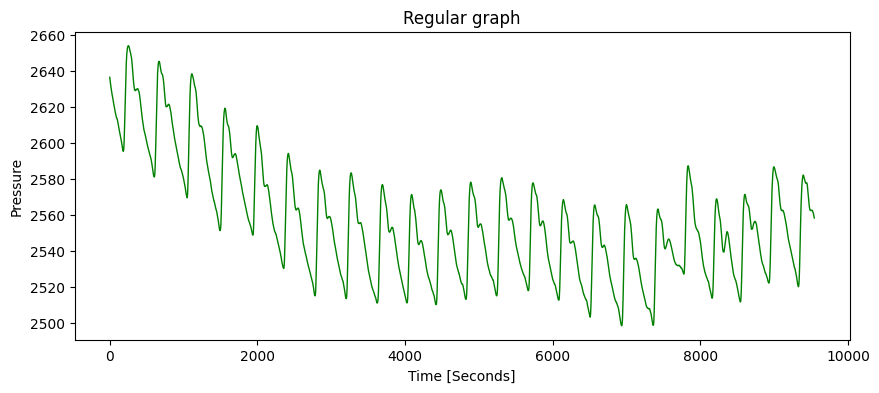

In [5]:
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a002/a002.initial.Static_seated_challenge_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(10, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "green")

plt.title("Regular graph")
# plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("Time [Seconds]")
plt.show()

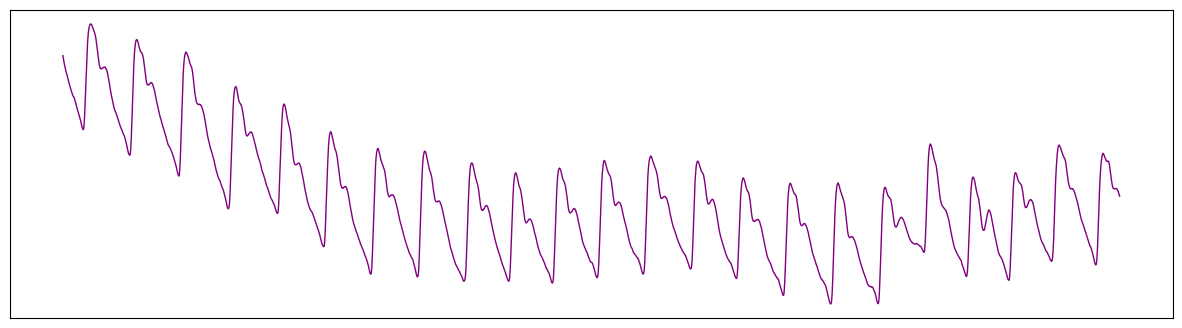

In [6]:
#path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a004/a004.initial.Exercise_challenge_start_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(15, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.xticks([])
plt.yticks([])

plt.show()

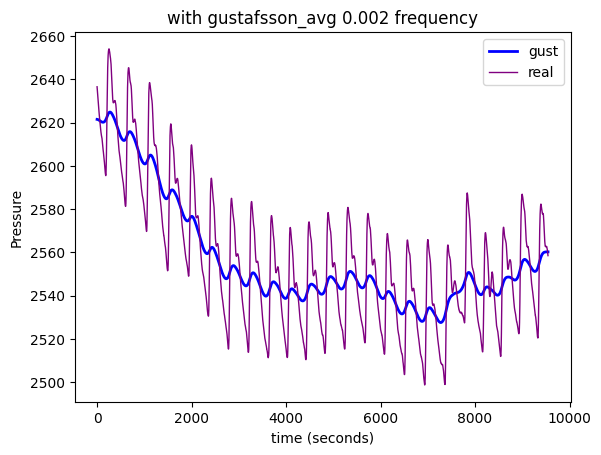

In [7]:
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


b, a = signal.butter(1, 0.002, analog=False)
gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
plt.plot(gustafsson_avg, 'b-', linewidth=2, label='gust',)
plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.title("with gustafsson_avg 0.002 frequency")
plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.show()

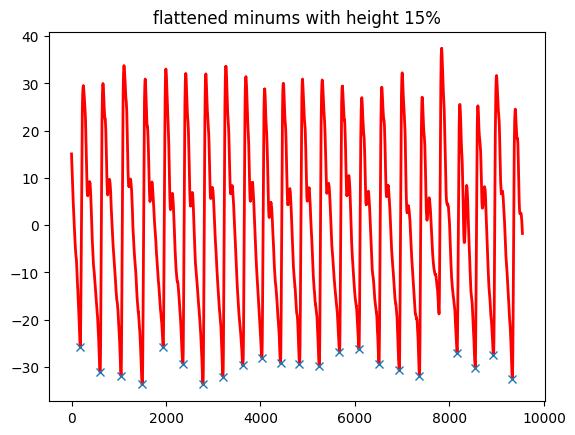

In [8]:

# df = pd.read_csv(path,sep = '\t')   
# pos_pressure = df["pressure"]

y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

y_flater = np.array(y_flater)
neglist = [ -x for x in y_flater]

neg_max_values = max(neglist)
neg_mix_values = min(neglist)
mid_neg_value= neg_max_values - neg_mix_values

min_height = neg_max_values - mid_neg_value*0.15 

min_peaks, _ = find_peaks(neglist , height= min_height, width=50)


plt.plot(y_flater, color="red", linewidth=2)
plt.plot(min_peaks, y_flater[min_peaks], "x",)
plt.title("flattened minums with height 15%")
plt.show()


In [9]:
most_accurate_mins = min_peaks
diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

mean_new_min = float(diffrences_new_min.mean())
overlapped_means = pd.DataFrame( )

nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)

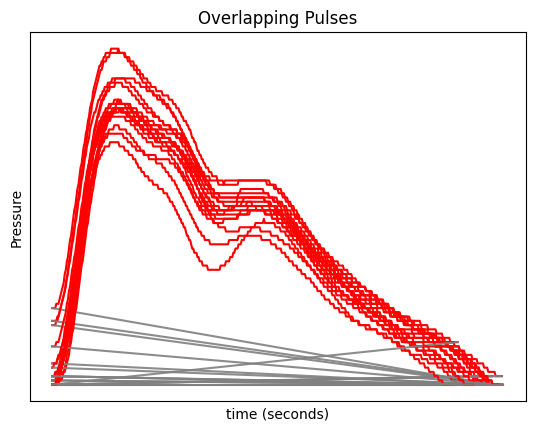

In [10]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_of_shift, color="red")
        plt.plot(start_end_line,color="grey" , alpha=0.9)


plt.title("Overlapping Pulses")
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.xticks([])
plt.yticks([])

plt.show()

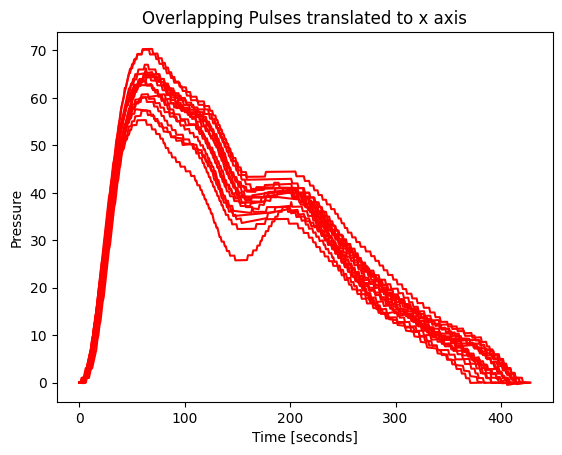

In [11]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_rotated, color="red")


plt.title("Overlapping Pulses translated to x axis")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")

plt.show()

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


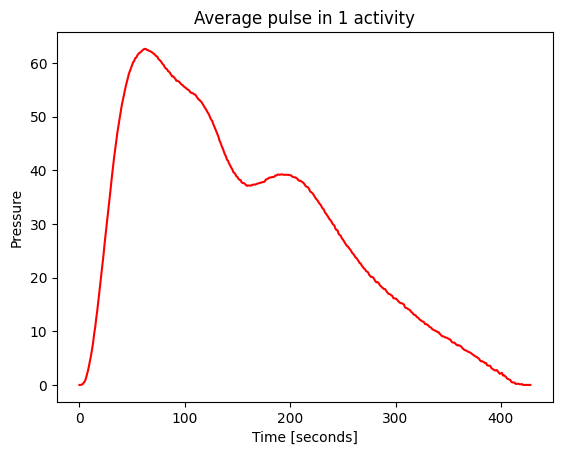

In [12]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']
plt.plot(all_overlaps_means, color='red')
plt.title("Average pulse in 1 activity")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")
contecting_it = np.linspace(all_overlaps_means[0], all_overlaps_means[-1], len(all_overlaps_means), endpoint=True)
plt.show()
all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']


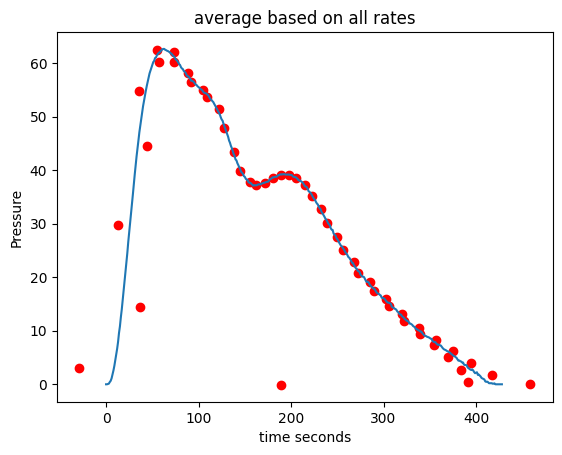

In [13]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']

resampled_y = signal.resample(all_overlaps_means, 50)
resampled_x = signal.resample(list(range(len(all_overlaps_means))), 50)


plt.plot(resampled_x,resampled_y,  'ro' )
plt.plot(all_overlaps_means )

plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")

plt.show()

Demos are done.


Training Models:

Making the chart for aurora

In [14]:

# LinearRegression_MAE_cross(-1, "s",1000)

# KNN_MAE_cross(-1, "s",1000)

# CNN_MAE_cross(-1, "s",1000)

# #or Run no overlap in participants , 0=Calibration_start recordings

# LinearRegression_MAE_cross(0, "s",50)

# KNN_MAE_cross(0, "s",50)

# CNN_MAE_cross(0, "s",50)

# CNN_MAE_cross_simvreal(6,"c")



Done with Auroa and Charlton

Now I want to makethe graph chart

In [15]:
# all_models = {}

# for i in range(len(keys_for_grouping)):
#     all_models[keys_for_grouping[i]]= [LinearRegression_MAE_cross(i, "s",50),KNN_MAE_cross(i, "s",50) , CNN_MAE_cross(i, "s",10)]

# list_results = []
# for i in range(0,7):
#     list_results.append(CNN_MAE_cross_both(i,"c"))

# print(list_results)



Showing clustering

In [97]:
auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_activity(0)
#auscultatory_pressure_real, auscultatory_sbp_real, auscultatory_dbp_real = filter_by_hypertension(-1)

In [81]:
len(filter_by_hypertension(0)[0])

226

In [83]:
# #this prints all the pulses
# from sklearn.cluster import KMeans
# n_clusters=110
# kmeans = KMeans(n_clusters=n_clusters)

# y = kmeans.fit_predict(auscultatory_pressure_real)

# #print(y)
# for j in range(n_clusters):
#     indexes = [idx for idx, val in enumerate(y) if val == j]
#     dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
#     dbp_variation=list(dbp_variation)
#     sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
#     sbp_variation =list(sbp_variation)
#     #print(sbp_variation)
#     print(round(get_stats(dbp_variation)[3],1), round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
#     print(round(get_stats(sbp_variation)[3],1), round(get_stats(sbp_variation)[4] - get_stats(sbp_variation)[3],1))
#     for i in indexes:
#         plt.plot(auscultatory_pressure_real[i], color="#ED2B2A")
#     #plt.title(f"With {len(indexes)} in the group")
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

In [100]:
# I want to show as you add a pulse the avegera SD error goes down
from sklearn.cluster import KMeans
# n_clusters=110
# kmeans = KMeans(n_clusters=n_clusters)

# y = kmeans.fit_predict(auscultatory_pressure_real)

# #print(y)
# for j in range(n_clusters):
    # indexes = [idx for idx, val in enumerate(y) if val == j]
    # dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
    # dbp_variation=list(dbp_variation)
    # sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
    # sbp_variation =list(sbp_variation)
    # #print(sbp_variation)
    # print(round(get_stats(dbp_variation)[3],1), round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
#     print(round(get_stats(sbp_variation)[3],1), round(get_stats(sbp_variation)[4] - get_stats(sbp_variation)[3],1))
#     for i in indexes:
#         plt.plot(auscultatory_pressure_real[i], color="#ED2B2A")
#     #plt.title(f"With {len(indexes)} in the group")
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

all_kmeans_sd =[]
all_kmeans_mean =[]
all_kmeans_numbers = []
for k in range(1, 200):

    
    kmeans = KMeans(n_clusters=k,  max_iter = 500).fit(auscultatory_pressure_real)
    y = kmeans.fit_predict(auscultatory_pressure_real)
    #print(y)
    list_kmean_sd =[]
    list_kmean_mean =[]
    list_kmean_nums =[]
    for j in range(k):
        indexes = [idx for idx, val in enumerate(y) if val == j]
        dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
        dbp_variation=list(dbp_variation)
        sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
        sbp_variation =list(sbp_variation)
        #print(sbp_variation)
        list_kmean_mean.append(round(get_stats(dbp_variation)[3],1) )
        list_kmean_sd.append(round(get_stats(dbp_variation)[4] - get_stats(dbp_variation)[3],1) )
        list_kmean_nums.append(len(indexes))
    all_kmeans_sd.append(sum(list_kmean_sd) / len(list_kmean_sd))
    all_kmeans_mean.append(sum(list_kmean_mean) / len(list_kmean_mean))
    all_kmeans_numbers.append(sum(list_kmean_nums) / len(list_kmean_nums))

/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/101306008.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/101306008.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sbp_variation = [float(i) for j, i in enumerate(list(auscultatory_sbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_32341/101306008.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dbp_variation = [float(i) for j, i in enumerate(list(auscultatory_dbp_real)) if j in indexes]
/var/folders/hp/g2knsnlj4y18ybnh9bjz7

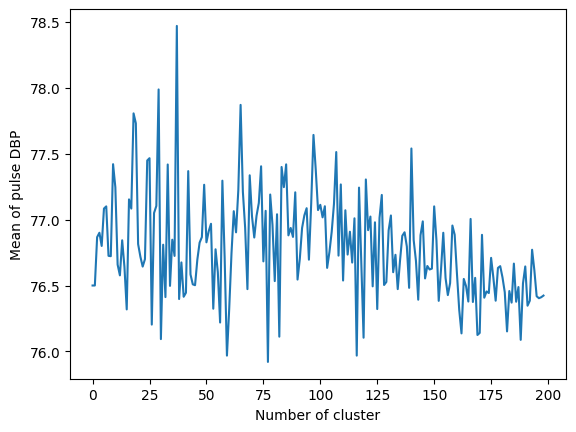

In [102]:
len(all_kmeans_sd)
plt.figure()
plt.plot(list(range(len(all_kmeans_mean))), list(all_kmeans_mean))
plt.xlabel("Number of cluster")
plt.ylabel("Mean of pulse DBP")
plt.show()

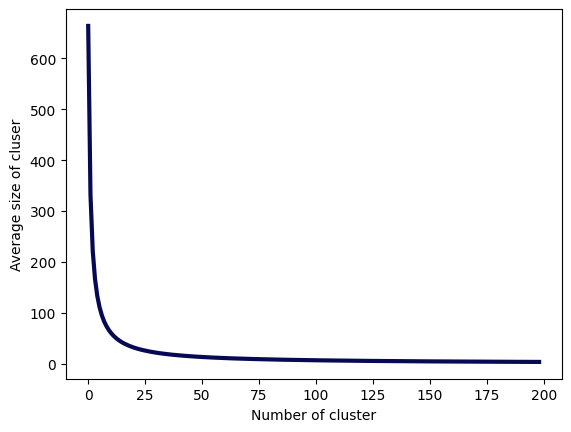

In [103]:
len(all_kmeans_sd)
plt.figure()
plt.plot(list(range(len(all_kmeans_numbers))), list(all_kmeans_numbers),linewidth=3,color= "#070A52")
plt.xlabel("Number of cluster")
plt.ylabel("Average size of cluser")
plt.show()

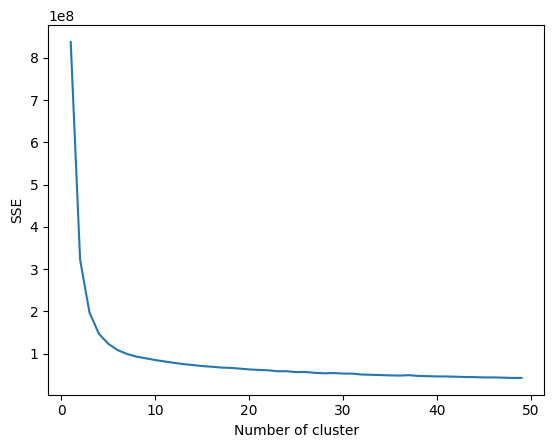

In [27]:
sse = {}
list_clusters= [ ]
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k,  max_iter = 500).fit(auscultatory_pressure_real)
    
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

    # sse[k] = sum(np.min(cdist(auscultatory_pressure_real, kmeanModel.cluster_centers_,
    #                                     'euclidean'), axis=1)) / auscultatory_pressure_real.shape[0]
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [20]:
auscultatory_pressure_simulated, auscultatory_dbp_simulated = filter_charlton_subjects()

In [21]:
# from sklearn.cluster import KMeans
# n_clusters=10
# kmeans = KMeans(n_clusters=n_clusters)

# y = kmeans.fit_predict(auscultatory_pressure_simulated)

# #print(y)
# for j in range(n_clusters):
#     indexes = [idx for idx, val in enumerate(y) if val == j]

#     dps_variation = [i for j, i in enumerate(auscultatory_dbp_simulated) if j not in indexes]
#     print([get_stats(dps_variation)[3], get_stats(dps_variation)[4] - get_stats(dps_variation)[3] ])
#     for i in indexes:
#         plt.plot(auscultatory_pressure_simulated[i], color= "#070A52")
#     #plt.title(f"With {len(indexes)} in the group")
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

<Figure size 1000x1000 with 0 Axes>

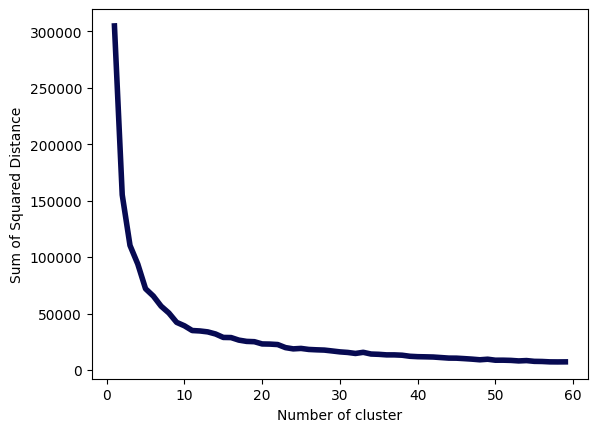

In [22]:
plt.figure(figsize=(10, 10)) 
sse = {}
list_clusters= [ ]
for k in range(1, 60):
    kmeans = KMeans(n_clusters=k,  max_iter = 500).fit(auscultatory_pressure_simulated[:])
    
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

    # sse[k] = sum(np.min(cdist(auscultatory_pressure_real, kmeanModel.cluster_centers_,
    #                                     'euclidean'), axis=1)) / auscultatory_pressure_real.shape[0]
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), linewidth=4, color= "#070A52")
plt.xlabel("Number of cluster")
plt.ylabel("Sum of Squared Distance")
plt.show()

In [23]:
from sklearn.cluster import MeanShift
import numpy as np
X = auscultatory_pressure_simulated
clustering = MeanShift(bandwidth=30).fit(X)
clustering.labels_
# clustering.predict([[0, 0], [5, 5]])
# clustering

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1])